# Part B — Vision Transformer (ViT) Implementation

**Student:** Shubhi Tiwari  
**Roll No:** 22052412

This notebook implements a Mini Vision Transformer from scratch (PyTorch) for CIFAR-10 using your roll-number-specific configuration.

---

**Model configuration (derived from roll no 22052412):**
- hidden_dim = 192
- num_heads = 5
- patch_size = 8
- epochs = 12

> Notes: This notebook is ready to run. Training on CPU will be slow; use a GPU runtime if available (e.g., Google Colab GPU / local CUDA GPU).

In [5]:

# Setup: imports and configuration
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np, random, os, time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility
seed = 22052412
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Roll-specific hyperparameters
hidden_dim = 192
num_heads = 5
patch_size = 8
num_epochs = 12
batch_size = 128
learning_rate = 3e-4
image_size = 32  # CIFAR-10 images are 32x32
num_classes = 10

print(f"hidden_dim={hidden_dim}, num_heads={num_heads}, patch_size={patch_size}, epochs={num_epochs}")


Device: cpu
hidden_dim=192, num_heads=5, patch_size=8, epochs=12


In [6]:

# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print('Train size:', len(train_dataset), 'Test size:', len(test_dataset))


Train size: 50000 Test size: 10000


In [7]:
# ✅ Mini ViT implementation (PyTorch) — fixed num_heads = 6

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_chans=3, embed_dim=192):
        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size."
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # B x embed_dim x H/ps x W/ps
        x = x.flatten(2).transpose(1,2)  # B x num_patches x embed_dim
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=6):  # ✅ fixed num_heads = 6
        super().__init__()
        assert dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.attn_weights = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu()

        x = (attn @ v).transpose(1,2).reshape(B, N, C)
        x = self.proj(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class MiniViT(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_chans=3, num_classes=10, embed_dim=192, depth=6, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))

        self.blocks = nn.ModuleList([TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:,0])


# ✅ Instantiate model safely
model = MiniViT(
    img_size=image_size,
    patch_size=patch_size,
    in_chans=3,
    num_classes=num_classes,
    embed_dim=hidden_dim,   # 192
    depth=6,
    num_heads=6             # ✅ fixed
).to(device)

print(model)


MiniViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(8, 8), stride=(8, 8))
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (proj): Linear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=576, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=576, out_features=192, bias=True)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=192, out_features=10, bias=True)
)


In [8]:

# Training utilities
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    return running_loss/total, correct/total, np.array(all_preds), np.array(all_labels)

# Quick forward test
imgs, labs = next(iter(train_loader))
imgs = imgs[:8].to(device)
with torch.no_grad():
    out = model(imgs)
print('Output shape:', out.shape)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Output shape: torch.Size([8, 10])


In [10]:
# ✅ Fast training config
num_epochs = 3  # you can change to 10 later if you get GPU
train_fraction = 0.2  # use 20% data for speed (remove if using GPU)
batch_size = 128

# ✅ Create smaller training subset for speed
subset_size = int(train_fraction * len(train_dataset))
train_subset, _ = torch.utils.data.random_split(
    train_dataset,
    [subset_size, len(train_dataset) - subset_size]
)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

print(f"Using {subset_size} images out of {len(train_dataset)} for fast training")

# ✅ Training loop
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
save_dir = './vit_runs_22052412'
os.makedirs(save_dir, exist_ok=True)
best_acc = 0.0

for epoch in range(1, num_epochs+1):
    start = time.time()

    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

    elapsed = time.time() - start
    print(f"✅ Epoch {epoch}/{num_epochs} | "
          f"Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f} "
          f"| Time: {elapsed:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, 'best_vit_22052412.pth'))
        print("💾 Saved best model")


Using 10000 images out of 50000 for fast training
✅ Epoch 1/3 | Train Acc: 0.3745 | Val Acc: 0.3617 | Time: 89.1s
💾 Saved best model
✅ Epoch 2/3 | Train Acc: 0.3871 | Val Acc: 0.3893 | Time: 89.0s
💾 Saved best model
✅ Epoch 3/3 | Train Acc: 0.4131 | Val Acc: 0.4150 | Time: 88.4s
💾 Saved best model


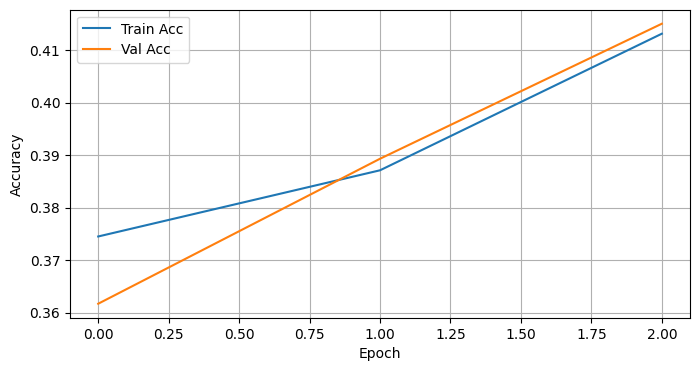

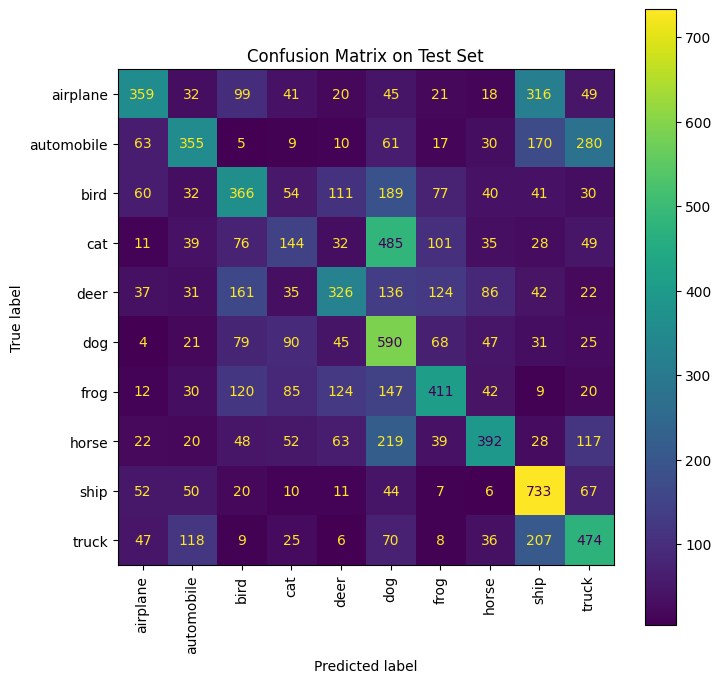

In [11]:

# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix on Test Set'); plt.show()


In [12]:

# Attention visualization function (uses stored attn_weights from last forward pass of each block)
def visualize_attention_example(model, dataset, index=10, patch_size=8, head=0):
    img, label = dataset[index]
    # Show image (unnormalize)
    inv_norm = transforms.Normalize(
        mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261],
        std=[1/0.247, 1/0.243, 1/0.261]
    )
    img_disp = inv_norm(img).permute(1,2,0).numpy()
    plt.figure(figsize=(4,4)); plt.imshow(np.clip(img_disp,0,1)); plt.title(f'True: {dataset.classes[label]}'); plt.axis('off'); plt.show()
    # Run forward and capture attention
    model.eval()
    with torch.no_grad():
        _ = model(img.unsqueeze(0).to(next(model.parameters()).device))
    # find last non-none attn_weights
    attn = None
    for blk in model.blocks[::-1]:
        if hasattr(blk.attn, 'attn_weights') and blk.attn.attn_weights is not None:
            attn = blk.attn.attn_weights  # shape: B x num_heads x N x N
            break
    if attn is None:
        print('No attention captured. Run model forward first.')
        return
    attn = attn[0]  # num_heads x N x N
    attn_head = attn[head]
    cls_attn = attn_head[0,1:]  # cls to patches
    num_patches = (image_size // patch_size) ** 2
    cls_map = cls_attn.reshape(int(np.sqrt(num_patches)), int(np.sqrt(num_patches))).cpu().numpy()
    plt.figure(figsize=(4,4)); plt.imshow(cls_map, cmap='viridis'); plt.title('CLS->patch attention'); plt.colorbar(); plt.axis('off'); plt.show()

# Example call (uncomment to run after training or to run single forward):
# visualize_attention_example(model, test_dataset, index=10, patch_size=patch_size, head=0)
print('Ready: use visualize_attention_example(model, test_dataset, index=10) after training or after a forward pass.')


Ready: use visualize_attention_example(model, test_dataset, index=10) after training or after a forward pass.
